# Prelim output for Deepak (Bay of Bengal)

In [2]:
from xarrayutils.visualization import Movie
import numpy as np
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline
from xmitgcm import open_mdsdataset
import xgcm
import xmitgcm
from aviso_surface_tracer import convert_trnum2dimension
from xarrayutils.utils import concat_dim_da

/rigel/ocp/users/jb3210/code/src/xarrayutils/xarrayutils/visualization.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/rigel/ocp/users/jb3210/conda/envs/standard/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/rigel/ocp/users/jb3210/conda/envs/standard/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/rigel/ocp/users/jb3210/conda/envs/standard/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/rigel/ocp/users/jb3210/conda/envs/standard/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/rigel/ocp/

In [3]:
from dask.distributed import Client
client = Client(scheduler_file='/rigel/home/jb3210/scheduler.json')

In [4]:
client#.restart()

Client Scheduler: tcp://10.43.5.22:8786 Dashboard: http://10.43.5.22:8787/status,Cluster Workers: 11 Cores: 44 Memory: 221.26 GB


In [5]:
# Read in all of the runs
ddir = '/rigel/ocp/users/jb3210/projects/aviso_surface_tracer/runs'
# runnames = ['PSI', 'SST', 'SSS', 'LAT']
# runs = ['run_KOC_%s_variance_budget_new' %a for a in runnames]
runs = ['run_sst_AMSRE_damped_1m_hr_output']
rundirs = [os.path.join(ddir,run) for run in runs]
timestep = 900 # in seconds

# datasets = [open_mdsdataset(rundir, prefix=['tracer_diags'],
#                      delta_t=timestep, ref_date='1993-01-01') for rundir in rundirs]

In [6]:
# limit the files read...otherwise it takes sooooo long to read them in 
iters= range(659988,842244, 8*12)

In [7]:
ds = open_mdsdataset(rundirs[0], prefix=['tracer_snapshots'],delta_t=timestep,iters=iters, ref_date='1993-01-01')

/rigel/ocp/users/jb3210/code/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/ocp/users/jb3210/code/src/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [8]:
# ds = convert_trnum2dimension(ds)
ds

<xarray.Dataset>
Dimensions:  (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 1899)
Coordinates:
    iter     (time) int64 dask.array<shape=(1899,), chunksize=(1,)>
  * time     (time) datetime64[ns] 2011-10-28T21:00:00 2011-10-29T21:00:00 ...
  * YG       (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 -79.2 ...
  * YC       (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG       (XG) >f4 -2.7755576e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * XC       (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 ...
  * Zu       (Zu) float32 -100.0
  * Z        (Z) float32 -50.0
  * Zl       (Zl) float32 0.0
  * Zp1      (Zp1) float32 0.0 -100.0
    rAw      (YC, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    dxC      (YC, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    dyC      (YG, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1600, 3600)>
    Depth    (YC, XC) >f4 dask.array<

In [9]:
# Calculate Gradient
from xgcm import Grid
grid = Grid(ds)
dqdx = grid.diff(ds.TRAC01, 'X') / ds.dxC * ds.hFacW
dqdy = grid.diff(ds.TRAC01, 'Y') / ds.dyC * ds.hFacS
gradq = xr.ufuncs.sqrt((grid.interp(dqdx,'X') ** 2) + 
                       (grid.interp(dqdy,'Y') ** 2))
ds['grad_TRAC01'] = gradq

In [11]:
region = dict(XC=slice(70,110), YC=slice(5,25))
export = ds.where(ds.hFacC).sel(**region).sel(time=slice('2013-01-01', '2016-01-01'))
export.nbytes/1e9

0.74724078

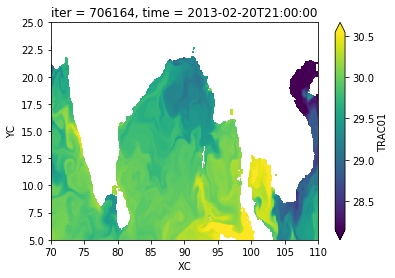

In [12]:
export.TRAC01.isel(time=50).plot(robust=True)

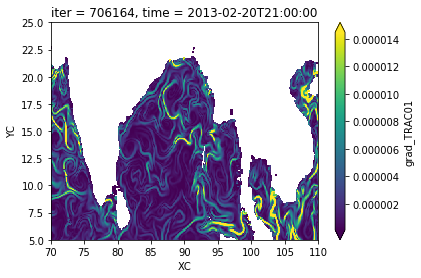

In [13]:
export.grad_TRAC01.isel(time=50).plot(robust=True)

In [14]:
export.TRAC01

<xarray.DataArray 'TRAC01' (time: 1096, YC: 200, XC: 400)>
dask.array<shape=(1096, 200, 400), dtype=float32, chunksize=(1, 200, 400)>
Coordinates:
    iter     (time) int64 dask.array<shape=(1096,), chunksize=(1,)>
  * time     (time) datetime64[ns] 2013-01-01T21:00:00 2013-01-02T21:00:00 ...
  * YC       (YC) >f4 5.05 5.15 5.25 5.35 5.45 5.55 5.65 5.75 5.85 5.95 6.05 ...
  * XC       (XC) >f4 70.05 70.15 70.25 70.35 70.45 70.55 70.65 70.75 70.85 ...
    Depth    (YC, XC) >f4 dask.array<shape=(200, 400), chunksize=(200, 400)>
    rA       (YC, XC) >f4 dask.array<shape=(200, 400), chunksize=(200, 400)>
    hFacC    (YC, XC) >f4 dask.array<shape=(200, 400), chunksize=(200, 400)>
Attributes:
    long_name:      TR1 concentration
    units:          kg/kg
    standard_name:  TRAC01

In [15]:
movdir1 = '../outbox/Deepak/movie/tracer'
movdir2 = '../outbox/Deepak/movie/grad_tracer'
# Render tracer movie
Movie(export.TRAC01, movdir1, clim=[28.5, 30.5])
Movie(export.grad_TRAC01, movdir2, clim=np.array([1, 15])*1e-6)

+++ Execute plot function +++


distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}


+++ Convert frames to video +++
+++ Execute plot function +++


distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather keys {"('array-6f635abaca3668584d3c843625e38100', 0)": []}
distributed.client - WARNING - Couldn't gather

+++ Convert frames to video +++


In [16]:
# save out subset of data
export.load().to_netcdf('../outbox/Deepak/data/BOB.nc')